<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [1005]:
%%capture
pip install pyswarms

In [1006]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [1007]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [1008]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [1009]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [1010]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [1011]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [1012]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [1013]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [1014]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [1015]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [1016]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [1017]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


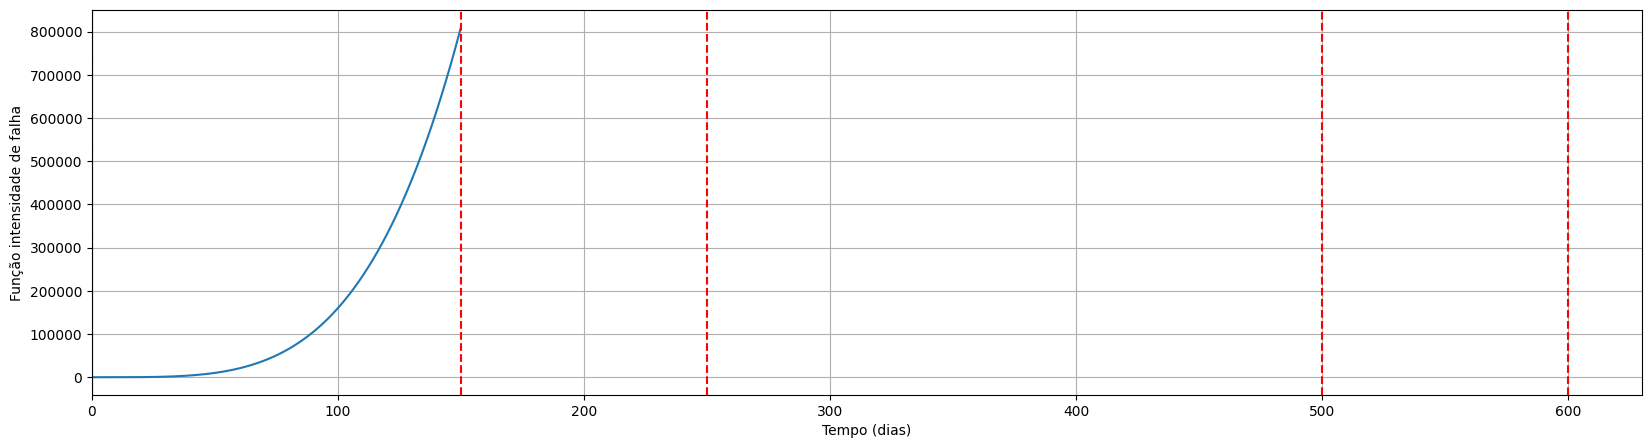

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [1018]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [1025]:
def objective_st(x):
    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    # Criação de variáveis para os parâmetros
    global s
    T = [0]
    s_row = []
    cont = 0

    k = df['k']
    ck = df['c'].max()
    n = []
    s = []
    # Iterar sobre os elementos de x usando np.nditer()
    with np.nditer(x, op_flags=['readwrite']) as it:
        for number in it:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    for row in range(m):
        s.append(s_row)

    if ck == 0:
        return MAX_VALUE_CUSTO

    num_ciclos = ck

    for k in range(m):
        n.append(list(df['n'][k * ck:(k + 1) * ck]))
        s_row = []
        for j in range(num_ciclos):
            s_row.append(df['s'][k * ck + j])
        s.append(s_row)

   # Obter os tempos para manutenções preventivas
    T = list(df['T'][:m])
    tempos_mp = T[1:]

    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    termos_somatorio = [((1 / (lamb ** beta)) * (T[1] ** beta))]
    numero_medio_falhas = [0, ((1 / (lamb ** beta)) * (T[1] ** beta))]

    for i in range(ck - 1):
        termo = (((T[i + 2] - fator[i] * T[i + 1]) ** beta) - (((1 - fator[i]) * T[i + 1]) ** beta)) * (1 / (lamb ** beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    final = 730
    termo = (((final - fator[ck - 1] * T[ck]) ** beta) - (((1 - fator[ck - 1]) * T[ck]) ** beta)) * (1 / (lamb ** beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    Ctotal = []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i + 1] - mi[i]) * CMC) / (T[i + 1] - T[i]))

    cmp = custo_mp(s[0][ck - 1], CMP)
    Ctotal.append((cmp + (mi[ck + 1] - mi[ck]) * CMC) / (final - T[ck]))
    Custo = np.sum(Ctotal)

    # Formatar o valor do custo
    Custo_formatado = format(Custo, '.2f')
    Custo_formatado = Custo_formatado.replace('.', '').replace(',', '.')

    print("")
    print("=========================================================================")
    print("")

     # Imprimir o custo total para manutenções preventivas
    print("Custo Total:", Custo_formatado)

     # Imprimir o número de ciclos de manutenção
    print("Número de Ciclos de Manutenção:", num_ciclos)

    # Imprimir os tempos para manutenções preventivas
    print("Tempos para Manutenções Preventivas:", tempos_mp)

    # Imprimir os tempos para manutenções preventivas
    print("Número de Sisemas:", m)

    # Imprimir a severidade para cada ciclo de manutenção
    print("=========================================================================")
    print("")
    for k in range(m):
        for i in range(num_ciclos):
            if not np.isnan(s[k][i]):
                print("Severidade para Ciclo de Manutenção", i+1, "do Sistema", k+1, ":", s[k][i])

    return Custo

In [1028]:
num_particles = 100
max_iterations = 30
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-07-07 00:45:38,373 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  13%|█▎        |4/30, best_cost=9.09e+10



Custo Total: 30527621870379
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:  23%|██▎       |7/30, best_cost=9.09e+10



Custo Total: 38802406788415
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best:  40%|████      |12/30, best_cost=9.09e+10



Custo Total: 20853682765929
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 3 do S

pyswarms.single.global_best:  40%|████      |12/30, best_cost=9.09e+10

 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.5
Severidade para Ciclo d

pyswarms.single.global_best:  57%|█████▋    |17/30, best_cost=7.07e+10

do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.25


Custo Total: 38802406791954
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Cic

pyswarms.single.global_best:  67%|██████▋   |20/30, best_cost=3.57e+10



Custo Total: 9660284422195
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema

pyswarms.single.global_best:  83%|████████▎ |25/30, best_cost=3.57e+10



Custo Total: 17361599447217
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best:  90%|█████████ |27/30, best_cost=3.57e+10


Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.75


Custo Total: 11006499177090
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 d

pyswarms.single.global_best: 100%|██████████|30/30, best_cost=3.57e+10
2023-07-07 00:45:40,201 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.34732807 5.08314138 2.37494104]
2023-07-07 00:45:40,203 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:40,326 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.33180843 0.01781695 2.30317743]
2023-07-07 00:45:40,329 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 4595802422065
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:40,378 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.37500806 3.41410719 2.33846543]
2023-07-07 00:45:40,379 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 14442986042750
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 7065288907435
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:40,432 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.40758251 6.07390908 2.37867477]
2023-07-07 00:45:40,476 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


0.25


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10



Custo Total: 3573205578107
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do


2023-07-07 00:45:40,546 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.41992072 0.73134006 2.41457804]
2023-07-07 00:45:40,548 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:40,569 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.41738481 1.74547941 2.43820568]
2023-07-07 00:45:40,572 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 20853682780083
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 3 d

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 35883793387487
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 3 do Si

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:40,595 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.40477671 2.01953477 2.4444667 ]
2023-07-07 00:45:40,597 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:40,618 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.37878031 2.21183585 2.42977326]
2023-07-07 00:45:40,620 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 26586411600724
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1, best_cost=3.57e+10



Custo Total: 20853682765929
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 3 do S

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:40,660 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.34728608 2.23136354 2.41406134]
2023-07-07 00:45:40,662 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:40,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.31894285 1.93149907 2.39573988]
2023-07-07 00:45:40,893 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 30527621852686
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:40,911 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.29826088 1.0344723  2.3748854 ]
2023-07-07 00:45:40,913 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 28955223185422
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:40,928 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.28963135 6.58257932 2.35612026]
2023-07-07 00:45:40,930 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 26586411600724
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:40,946 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.29116343 4.57154737 2.341566  ]
2023-07-07 00:45:40,947 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 14442986042750
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:40,960 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.30531923 2.12140496 2.32855907]
2023-07-07 00:45:40,962 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 17361599447217
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:41,032 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.32486583 6.8447982  2.31861941]
2023-07-07 00:45:41,034 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 13420389177562
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10



Custo Total: 4595802422065
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do 


2023-07-07 00:45:41,048 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.3479375  3.82935034 2.31663437]
2023-07-07 00:45:41,049 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:41,063 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.36866326 0.49462731 2.31606189]
2023-07-07 00:45:41,065 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 26036609784494
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Si

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 6168201089329
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do Sist

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:41,258 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.38291047 4.42768774 2.32194431]


0.5
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.25


2023-07-07 00:45:41,432 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Custo Total: 7514415830070
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:41,486 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.39017816 1.11929833 2.33314072]
2023-07-07 00:45:41,487 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.5


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:41,523 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.38450933 4.65644335 2.3512884 ]
2023-07-07 00:45:41,525 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 8087885772623
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sis

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:41,557 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.37127963 0.8969644  2.36905883]
2023-07-07 00:45:41,558 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 8087885772623
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sis

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:41,572 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.35751867 4.8157293  2.38552089]
2023-07-07 00:45:41,574 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 16912472528120
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 3 d

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:41,589 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.34407771 1.36801554 2.4002096 ]
2023-07-07 00:45:41,591 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 17361599447217
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:41,604 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.3323343  5.06726991 2.41027233]
2023-07-07 00:45:41,606 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 26586411618416
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1



Custo Total: 7514415826532
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:41,714 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.32377287 1.39763861 2.41543119]
2023-07-07 00:45:41,716 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 5 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 5 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 5 : 0.25


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:41,728 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.31718187 5.41759154 2.41223558]
2023-07-07 00:45:41,729 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 34861196554145
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:41,741 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.31687207 1.93676436 2.40071306]
2023-07-07 00:45:41,743 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 30527621870379
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.5
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.5
Severidade para Ciclo de Manutenção 3 do

pyswarms.single.global_best:   0%|          |0/1, best_cost=3.57e+10



Custo Total: 34861196554145
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:41,756 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.3247167  5.14240212 2.38732506]
2023-07-07 00:45:41,757 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Custo Total: 17361599429524


pyswarms.single.global_best:   0%|          |0/1, best_cost=3.57e+10

Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 4 : 0.75
Severida

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:42,119 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.33605759 1.01897133 2.37410506]
2023-07-07 00:45:42,125 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:42,191 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.34810098 4.4957918  2.36243456]
2023-07-07 00:45:42,194 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Custo Total: 28955223185422
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=3.57e+10
2023-07-07 00:45:42,216 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 35732055781.074524, best pos: [2.35883129 0.76519988 2.35393708]




Custo Total: 13420389177562
Número de Ciclos de Manutenção: 4
Tempos para Manutenções Preventivas: [150.0, 250.0, 500.0, 600.0]
Número de Sisemas: 5

Severidade para Ciclo de Manutenção 1 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 1 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 1 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 2 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 2 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 3 do Sistema 3 : 0.75
Severidade para Ciclo de Manutenção 4 do Sistema 3 : 0.25
Severidade para Ciclo de Manutenção 1 do Sistema 4 : 0.75
Severidade para Ciclo de Manutenção 2 do Sistema 4 : 0.25
Severidade para Ciclo de Manutenção 

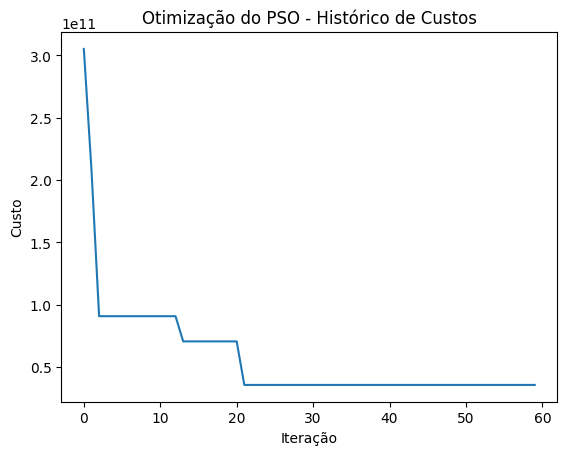

In [1029]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteração')
plt.ylabel('Custo')
plt.title('Otimização do PSO - Histórico de Custos')
plt.show()

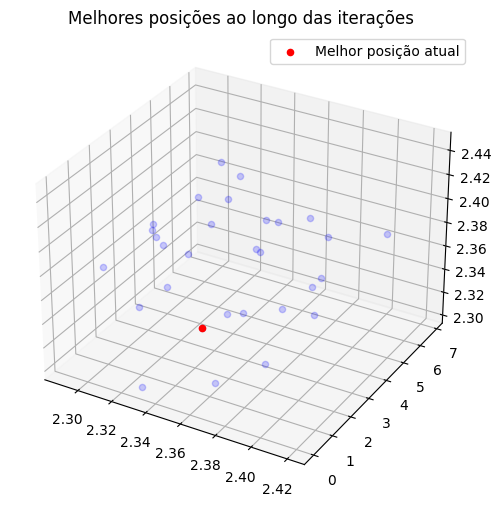

                              
*************************************************************************
Número total de iterações: 30
Número de Particulas: 100
Número de Dimensões: 3
                              
Melhor partícula: 134203891775.61842


In [1030]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], best_positions[i, 2], c='blue', alpha=0.2)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], best_positions[-1, 2], c='red', label='Melhor posição atual')

ax.set_title('Melhores posições ao longo das iterações')
ax.legend()
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])